# Taller Práctico: Regresión Logística (Versión Completa y Corregida)

**Curso:** Maestría en Machine Learning

**Nota:** Esta versión incorpora las correcciones de preprocesamiento discutidas: la correcta creación de variables dummy (0/1) y la estandarización de features numéricos, presentando el flujo de trabajo metodológicamente correcto y completo.

## 1. Importación de Librerías

In [160]:
#!pip install ISLP

In [1]:
# Librerías para manipulación de datos
import pandas as pd
import numpy as np

# Librerías para visualización
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt

# Librerías de Machine Learning (scikit-learn)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    roc_auc_score
)

# Librería para cargar el dataset
from ISLP import load_data

## 2. Carga y Preprocesamiento de Datos

In [2]:
# Carga de datos
default_df = load_data('Default')

# Conversión de categóricas a numéricas
df_processed = pd.get_dummies(default_df, columns=['student'], drop_first=True, dtype=int)
df_processed['default'] = df_processed['default'].apply(lambda x: 1 if x == 'Yes' else 0)

# Definición de features y target
X = df_processed[['balance', 'income', 'student_Yes']]
y = df_processed['default']

print("Primeras filas de los datos preprocesados:")
display(X.head())

Primeras filas de los datos preprocesados:


,balance,income,student_Yes
0,729.526495,44361.625074,0
1,817.180407,12106.134700,1
2,1073.549164,31767.138947,0
3,529.250605,35704.493935,0
4,785.655883,38463.495879,0


### División en Conjuntos de Entrenamiento y Prueba

Dividimos los datos ANTES de cualquier preprocesamiento que "aprenda" de los datos, como la estandarización, para evitar fuga de información.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")

    # # Muestra las primeras filas del conjunto de entrenamiento
    # print("Primeras filas de X_train:")
    # display(X_train.head())

    # # Muestra las primeras filas del conjunto de prueba
    # print("Primeras filas de X_test:")
    # display(X_test.head())

Forma de X_train: (8000, 3)
Forma de X_test: (2000, 3)


### Estandarización de Features Numéricos

**Este es un paso crucial.** Estandarizamos las variables `balance` e `income` para que tengan media 0 y desviación estándar 1. Esto asegura que la regularización del modelo se aplique de manera justa.

**Importante:** Ajustamos el `StandardScaler` **únicamente** con los datos de entrenamiento (`X_train`) y luego lo usamos para transformar tanto el conjunto de entrenamiento como el de prueba.

In [5]:
# Instanciamos el escalador
scaler = StandardScaler()

# Columnas a escalar
cols_to_scale = ['balance', 'income']

# Creamos copias para no modificar los dataframes originales
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Ajustamos y transformamos los datos de entrenamiento
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

# Transformamos los datos de prueba con el escalador ya ajustado
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

print("Primeras filas de los datos de entrenamiento escalados:")
display(X_train_scaled.head())

Primeras filas de los datos de entrenamiento escalados:


,balance,income,student_Yes
2720,-0.018061,-0.331140,1
6168,-1.687480,2.194023,0
7723,-0.123917,-0.288274,0
8128,0.155670,0.992420,0
3565,0.449485,-1.673192,1


## 3. Entrenamiento del Modelo de Regresión Logística

Ahora entrenaremos el modelo usando los datos estandarizados.

In [6]:
# Instanciamos y entrenamos el modelo con los datos escalados
log_reg = LogisticRegression(random_state=42)#, solver='liblinear')
log_reg.fit(X_train_scaled, y_train)

print("¡Modelo entrenado exitosamente con datos escalados!")

¡Modelo entrenado exitosamente con datos escalados!


## 4. Evaluación del Modelo

Procedemos a la evaluación completa del modelo sobre el conjunto de prueba escalado.

### 4.1. Matriz de Confusión y Métricas Clave

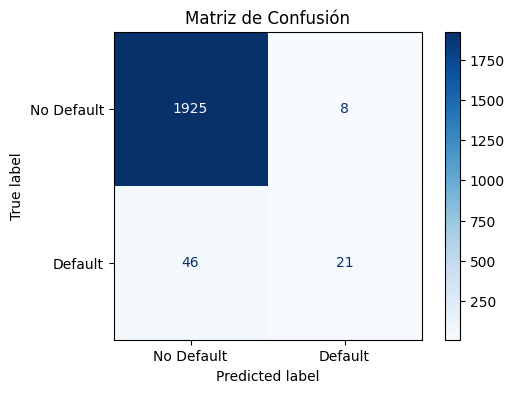


Reporte de Clasificación:
              precision    recall  f1-score   support

  No Default       0.98      1.00      0.99      1933
     Default       0.72      0.31      0.44        67

    accuracy                           0.97      2000
   macro avg       0.85      0.65      0.71      2000
weighted avg       0.97      0.97      0.97      2000



In [7]:
# Realizamos predicciones sobre el conjunto de prueba escalado
y_pred = log_reg.predict(X_test_scaled)

# Calculamos y visualizamos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Default', 'Default'])
fig, ax = plt.subplots(figsize=(6, 4))
disp.plot(cmap='Blues', ax=ax)
ax.set_title('Matriz de Confusión')
plt.show()

# Imprimimos el reporte de clasificación completo
print("\nReporte de Clasificación:")

 
 

print(classification_report(y_test, y_pred, target_names=['No Default', 'Default']))

### 4.2. El Impacto del Umbral de Decisión

Reporte de Clasificación con Umbral = 0.2:
              precision    recall  f1-score   support

  No Default       0.99      0.97      0.98      1933
     Default       0.39      0.63      0.48        67

    accuracy                           0.95      2000
   macro avg       0.69      0.80      0.73      2000
weighted avg       0.97      0.95      0.96      2000



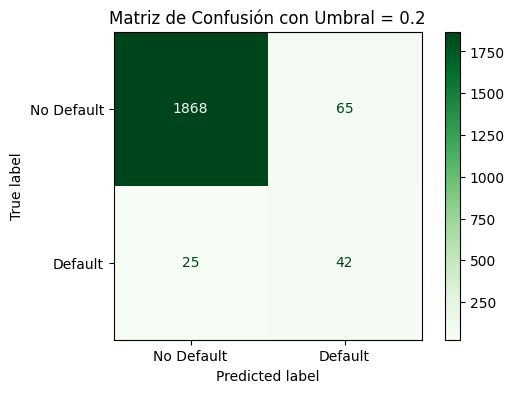

In [9]:
# Obtenemos las probabilidades de predicción para la clase positiva (Default)
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

# Aplicamos un nuevo umbral de 0.2 para aumentar el Recall
umbral = 0.2
y_pred_nuevo_umbral = (y_pred_proba >= umbral).astype(int)

print(f"Reporte de Clasificación con Umbral = {umbral}:")
print(classification_report(y_test, y_pred_nuevo_umbral, target_names=['No Default', 'Default']))

# Visualizamos la nueva matriz de confusión
cm_nuevo = confusion_matrix(y_test, y_pred_nuevo_umbral)
disp_nuevo = ConfusionMatrixDisplay(confusion_matrix=cm_nuevo, display_labels=['No Default', 'Default'])
fig, ax = plt.subplots(figsize=(6, 4))
disp_nuevo.plot(cmap='Greens', ax=ax)
ax.set_title(f'Matriz de Confusión con Umbral = {umbral}')
plt.show()

### 4.3. Curva ROC y AUC

In [10]:
# Calculamos la tasa de verdaderos positivos (tpr) y la tasa de falsos positivos (fpr)
fpr, tpr, umbrales = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Creamos el gráfico con Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'Curva ROC (AUC = {auc:.4f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Clasificador Aleatorio', line=dict(dash='dash')))
fig.update_layout(
    title='Curva ROC para el Modelo de Regresión Logística',
    xaxis_title='Tasa de Falsos Positivos (FPR)',
    yaxis_title='Tasa de Verdaderos Positivos (TPR)',
    template='plotly_white'
)
fig.show()

In [11]:
pd.DataFrame({
    'Umbral': umbrales,
    'FPR': fpr,
    'TPR': tpr
})  # Mostramos las primeras filas de los umbrales y sus correspondientes FPR y TPR

,Umbral,FPR,TPR
0,inf,0.000000,0.000000
1,0.904982,0.000000,0.014925
2,0.876104,0.000000,0.029851
3,0.861995,0.000517,0.029851
4,0.723316,0.000517,0.179104
...,...,...,...
87,0.007660,0.320228,0.970149
88,0.007620,0.320228,0.985075
89,0.007012,0.332644,0.985075
90,0.007008,0.332644,1.000000


## 5. Regularización

El hiperparámetro `C` en `scikit-learn` es el inverso de la fuerza de regularización $\lambda$. Un valor de `C` pequeño implica una regularización más fuerte. Ahora que los datos están escalados, la comparación de coeficientes es mucho más justa.

In [170]:
# Modelo con regularización L2 (Ridge) - C=1.0 (default)
log_reg_l2 = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', random_state=42).fit(X_train_scaled, y_train)

# Modelo con regularización L1 (Lasso) - C=1.0 (default)
log_reg_l1 = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', random_state=42).fit(X_train_scaled, y_train)

# Ahora con regularización más fuerte (C=0.1)
log_reg_l2_strong = LogisticRegression(penalty='l2', C=0.1, solver='liblinear', random_state=42).fit(X_train_scaled, y_train)
log_reg_l1_strong = LogisticRegression(penalty='l1', C=0.1, solver='liblinear', random_state=42).fit(X_train_scaled, y_train)

# Creamos un DataFrame para comparar los coeficientes
coef_df = pd.DataFrame({
    'Predictor': X.columns,
    'Coef_L2 (C=1.0)': log_reg_l2.coef_[0],
    'Coef_L1 (C=1.0)': log_reg_l1.coef_[0],
    'Coef_L2_fuerte (C=0.1)': log_reg_l2_strong.coef_[0],
    'Coef_L1_fuerte (C=0.1)': log_reg_l1_strong.coef_[0]
})

print("Comparación de Coeficientes con Regularización (Datos Escalados):")
display(coef_df)

Comparación de Coeficientes con Regularización (Datos Escalados):


,Predictor,Coef_L2 (C=1.0),Coef_L1 (C=1.0),Coef_L2_fuerte (C=0.1),Coef_L1_fuerte (C=0.1)
0,balance,2.594626,2.709366,1.921343,2.389894
1,income,-0.054058,-0.004069,-0.106268,0.002709
2,student_Yes,-0.658059,-0.561404,-0.670900,-0.323989


**Análisis:**
- Ahora los coeficientes son directamente comparables en magnitud.
- Se puede observar claramente cómo al aumentar la fuerza de la regularización (disminuir `C`), los coeficientes se "encogen" hacia cero.
- La regularización L1 es más agresiva y puede llevar coeficientes a cero, realizando una selección de variables.

## 6. Preguntas y Desafíos para Experimentar

Ahora te toca a ti. Intenta responder a las siguientes preguntas modificando el código anterior para solidificar tu aprendizaje:

1.  **Fuerza de Regularización vs. Rendimiento:** Crea un gráfico que muestre cómo cambia el AUC del modelo a medida que varías el hiperparámetro `C` (p. ej. `[0.001, 0.01, 0.1, 1, 10, 100]`). ¿Encuentras un valor óptimo para `C`?
2.  **Otros Escaladores:** En lugar de `StandardScaler`, prueba con `MinMaxScaler` de `sklearn.preprocessing`. ¿Cambian los resultados de rendimiento? ¿Y los coeficientes del modelo?
3.  **Selección de Predictores:** Entrena el modelo usando solo `balance` y `student_Yes` (ambos escalados). ¿Cuánto cae el rendimiento (AUC) al quitar la variable `income`? ¿Confirma esto que `income` es el predictor menos importante?

## 7. Ejercicios Propuestos

1.  Explica con tus propias palabras por qué el accuracy no es una buena métrica para evaluar un modelo en un dataset desbalanceado como `Default`.
2.  Si un banco te pide un modelo que minimice la cantidad de clientes en default que no son detectados, ¿en qué métrica te enfocarías (Precisión o Recall)? ¿Y cómo ajustarías el umbral de decisión?
3.  Carga un nuevo dataset de clasificación de `scikit-learn` (por ejemplo, `load_breast_cancer`) y realiza un análisis completo: estandarización, entrenamiento, evaluación con matriz de confusión y reporte de clasificación.
4.  ¿Qué representa un punto en la esquina superior izquierda de la curva ROC? ¿Y un punto en la línea diagonal?
5.  ¿Por qué es fundamental ajustar (`fit`) el `StandardScaler` únicamente con los datos de entrenamiento y no con todo el dataset?
6.  Crea un bucle `for` que itere sobre una lista de umbrales (ej. `[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]`). Para cada umbral, calcula y guarda la Precisión y el Recall para la clase 'Default'. Luego, grafica cómo cambian estas dos métricas a medida que varía el umbral (Precision-Recall Curve).
7.  Usando los coeficientes del modelo `log_reg` (entrenado con datos escalados), interpreta el coeficiente de la variable `balance`. ¿Qué significa un aumento de una desviación estándar en el `balance` en términos del odds ratio de default?
8.  Explica la diferencia fundamental entre la regularización L1 y L2 en términos de su efecto sobre los coeficientes del modelo.
9.  Si tuvieras dos modelos, uno con AUC de 0.85 y otro con AUC de 0.75, ¿cuál elegirías y por qué? ¿Bajo qué circunstancias podrías preferir el de 0.75?
10. Investiga el parámetro `class_weight` de `LogisticRegression` en `scikit-learn`. ¿Cómo podrías usarlo para manejar el desbalanceo de clases en el dataset `Default`? Pruébalo (con los datos escalados) y compara los resultados (recall, precisión) con la técnica de ajustar el umbral.

----------

### 1.  Explica con tus propias palabras por qué el accuracy no es una buena métrica para evaluar un modelo en un dataset desbalanceado como `Default`.

`Respuesta`: El accuracy puede ser engañoso en un dataset desbalanceado porque se basa en el porcentaje total de aciertos (TP + TN), sin importar la distribución de clases. Si la mayoría de los casos son "No Default", el modelo será bueno prediciendo esa clase, pero podria fallar en predecir los "Default".

---------------------------------------

----------

### 2.  Si un banco te pide un modelo que minimice la cantidad de clientes en default que no son detectados, ¿en qué métrica te enfocarías (Precisión o Recall)? ¿Y cómo ajustarías el umbral de decisión?

`Respuesta`: Recall, porque mide la capacidad de encontrar todos los positivos. Se podría intentar minimizar los falsos negativos.

---------------------------------------

----------

### 3.  Carga un nuevo dataset de clasificación de `scikit-learn` (por ejemplo, `load_breast_cancer`) y realiza un análisis completo: estandarización, entrenamiento, evaluación con matriz de confusión y reporte de clasificación.

`Respuesta`:

#### A) Carga y procesamiento de datos

In [16]:
# Librería para cargar el dataset
from sklearn.datasets import load_breast_cancer

# Carga del dataset de cáncer de mama
data_cancer = load_breast_cancer()

# Conversión de los datos a DataFrame y Series 
# ---> X: variables predictoras
# ---> y: variable objetivo
X = pd.DataFrame(data_cancer.data, columns=data_cancer.feature_names)
y = pd.Series(data_cancer.target, name='target')

print("Primeras filas de los datos preprocesados:")
display(X.head())

Primeras filas de los datos preprocesados:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


#### B) División en Conjuntos de Entrenamiento y Prueba

In [18]:
# Usamos train_test_split para separar los datos.
# ---> separamos el 20% de los datos para pruebas
# ---> usamos 42 como semilla para la aleatoriedad
# ---> usamos stratify para mantener la proporción de clases en y
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"X_train (muestras de entrenamiento, cant. de vbles predictoras) >> {X_train.shape}")
print(f"X_test (muestras para pruebas, cant. de vbles predictoras) >> {X_test.shape}")

X_train (muestras de entrenamiento, cant. de vbles predictoras) >> (455, 30)
X_test (muestras para pruebas, cant. de vbles predictoras) >> (114, 30)


#### C) Estandarización de Features Numéricos

In [19]:
# Instanciamos el escalador
scaler = StandardScaler()

# Creamos copias de los conjuntos de entrenamiento y prueba para no modificar los originales
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Ajustamos y transformamos los datos de entrenamiento
X_train_scaled[:] = scaler.fit_transform(X_train)

# Transformamos los datos de prueba con el escalador ya ajustado
X_test_scaled[:] = scaler.transform(X_test)

print("Primeras filas de los datos de entrenamiento escalados:")
display(X_train_scaled.head())

Primeras filas de los datos de entrenamiento escalados:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
546,-1.072001,-0.658425,-1.088080,-0.939274,-0.135940,-1.008718,-0.968359,-1.102032,0.281062,-0.113231,...,-1.034094,-0.623497,-1.070773,-0.876534,-0.169982,-1.038836,-1.078995,-1.350527,-0.352658,-0.541380
432,1.748743,0.066502,1.751157,1.745559,1.274468,0.842288,1.519852,1.994664,-0.293045,-0.320180,...,1.228342,-0.092833,1.187467,1.104386,1.517001,0.249655,1.178594,1.549916,0.191078,-0.173739
174,-0.974734,-0.931124,-0.997709,-0.867589,-0.613515,-1.138154,-1.092292,-1.243358,0.434395,-0.429247,...,-0.973231,-1.036772,-1.008044,-0.834168,-1.097823,-1.167260,-1.282241,-1.707442,-0.307734,-1.213033
221,-0.145103,-1.215186,-0.123013,-0.253192,0.664482,0.286762,-0.129729,-0.098605,0.555635,0.029395,...,-0.251266,-1.369643,-0.166633,-0.330292,0.234006,0.096874,-0.087521,-0.344838,0.242198,-0.118266
289,-0.771617,-0.081211,-0.803700,-0.732927,-0.672282,-1.006099,-0.798502,-0.684484,0.737495,-0.457213,...,-0.801135,0.079230,-0.824381,-0.741830,-0.911367,-0.984612,-0.933190,-0.777604,0.555118,-0.761639


#### D) Entrenamiento del Modelo de Regresión Logística

In [20]:
# Instanciamos el modelo de regresión logística
log_reg = LogisticRegression(random_state=42, max_iter=1000)  # Aumentamos max_iter para convergencia

# Entrenamos el modelo con los datos escalados
log_reg.fit(X_train_scaled, y_train)    

print("¡Modelo entrenado exitosamente con datos escalados!")

¡Modelo entrenado exitosamente con datos escalados!


#### E) Evaluación del modelo, con matriz y reporte

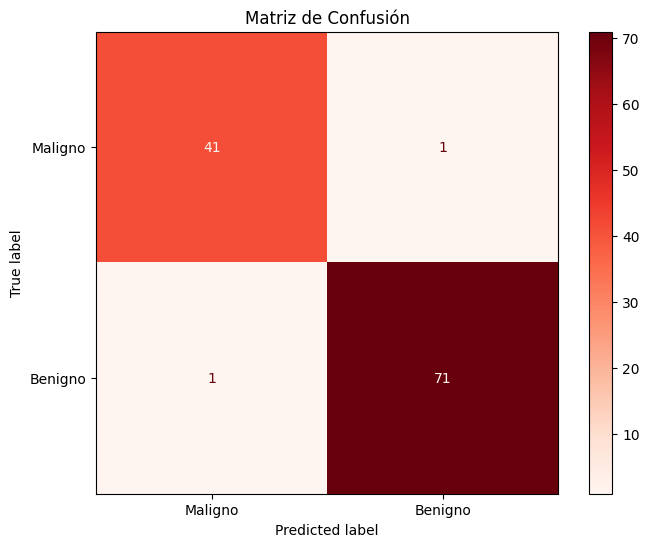


Reporte de Clasificación:
              precision    recall  f1-score   support

     Maligno       0.98      0.98      0.98        42
     Benigno       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [175]:
# Realizamos predicciones sobre el conjunto de prueba escalado
y_pred = log_reg.predict(X_test_scaled)  

# Calculamos y visualizamos la matriz de confusión
matriz = confusion_matrix(y_test, y_pred)

# Visualizamos la matriz de confusión
visualizacion = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=['Maligno', 'Benigno'])
fig, ax = plt.subplots(figsize=(8, 6))
visualizacion.plot(cmap='Reds', ax=ax)
ax.set_title('Matriz de Confusión')
plt.show()

# Imprimimos el reporte de clasificación completo
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['Maligno', 'Benigno']))


---------------------------------------

#### 4.  ¿Qué representa un punto en la esquina superior izquierda de la curva ROC? ¿Y un punto en la línea diagonal?

`Respuesta`: 
- Punto en esquina superior izquierda >>> representa un modelo casi perfecto, que clasifica correctamente todos los `default` y los `no default` (para el set de datos de cáncer de mama, clasifica correctamente todos los `Maligno` y los `Benigno`)

- Punto sobre la diagonal >>> indica que el modelo es aleatorio, es decir que existe la misma probabilidad de detectar un `default` que un `no default` (para el set de datos de cáncer de mama, `Maligno` y `Benigno`)

---------------------------------------

#### 5.  ¿Por qué es fundamental ajustar (`fit`) el `StandardScaler` únicamente con los datos de entrenamiento y no con todo el dataset?

`Respuesta`: si usamos los datos de test durante el proceo de ajuste del escalador, el modelo los utilizará para calcular la media y la desviación estándar. Esto llevará a que el modelo de la sensación de alto rendimiento, cuando en realidad lo que sucede, es que ya conoce los datos con los que está siendo testeado.

-----------------------------------------------

#### 6. Crea un bucle `for` que itere sobre una lista de umbrales (ej. `[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]`). Para cada umbral, calcula y guarda la Precisión y el Recall para la clase 'Default'. Luego, grafica cómo cambian estas dos métricas a medida que varía el umbral (Precision-Recall Curve).

`Respuesta`:


Reporte de Clasificación (Umbral = 0.1):
              precision    recall  f1-score   support

     Benigno       1.00      0.88      0.94        42
     Maligno       0.94      1.00      0.97        72

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114


Reporte de Clasificación (Umbral = 0.2):
              precision    recall  f1-score   support

     Benigno       1.00      0.95      0.98        42
     Maligno       0.97      1.00      0.99        72

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114


Reporte de Clasificación (Umbral = 0.3):
              precision    recall  f1-score   support

     Benigno       1.00      0.95      0.98        42
     Maligno       0.97      1.00      0.99        72

    accuracy                           0.98       114
  

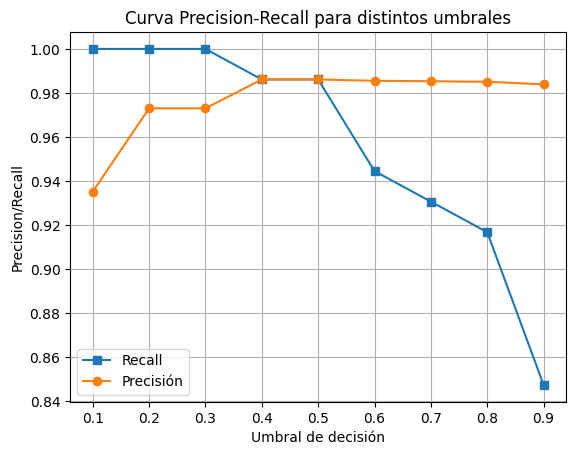

In [176]:
from sklearn.metrics import precision_score, recall_score

umbrales = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
precisiones = []
recalls = []

for umbral in umbrales:
    # Calculamos las probabilidades de predicción para la clase positiva (Maligno)
    y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

    # Aplicamos el umbral
    y_pred_nuevo_umbral = (y_pred_proba >= umbral).astype(int)
    
    # Imprimimos el reporte de clasificación
    print(f"\nReporte de Clasificación (Umbral = {umbral}):")
    print(classification_report(y_test, y_pred_nuevo_umbral, target_names=['Benigno', 'Maligno']))
    
    # # Visualizamos la matriz de confusión
    # matriz_nueva = confusion_matrix(y_test, y_pred_nuevo_umbral)
    # visualizacion_nueva = ConfusionMatrixDisplay(confusion_matrix=matriz_nueva, display_labels=['Banigno', 'Maligno'])
    # fig, ax = plt.subplots(figsize=(8, 6))
    # visualizacion_nueva.plot(cmap='Grays', ax=ax)
    # ax.set_title(f'Matriz de Confusión con Umbral = {umbral}')
    # plt.show()

    # Guardamos Precisión y Recall para graficar luego
    precisiones.append(precision_score(y_test, y_pred_nuevo_umbral))
    recalls.append(recall_score(y_test, y_pred_nuevo_umbral))

plt.plot(umbrales, recalls, marker='s', label='Recall')
plt.plot(umbrales, precisiones, marker='o', label='Precisión')
plt.xlabel('Umbral de decisión')
plt.ylabel('Precision/Recall')
plt.title('Curva Precision-Recall para distintos umbrales')
plt.legend()
plt.grid(True)
plt.show()

----------------------------------

#### 7.  Usando los coeficientes del modelo `log_reg` (entrenado con datos escalados), interpreta el coeficiente de la variable `balance`. ¿Qué significa un aumento de una desviación estándar en el `balance` en términos del odds ratio de default?

`Respuesta`: el coef de la vble "balance", en el modelo de regresión logística, indica cuánto cambia el logaritmo del odds, de estar en default cuando el balance o saldo se incrementa en una desviación estándar (siempre que se mantengan las demás variables constantes). Por ejemplo: 
- si el coeficiente de "balance" fuera 2.0, entonces, la probabilidad de estar en dafault se multiplica por `exp(2.0)`
- es decir que el riesgo de caer en default aumenta en aproximadamente 7 veces (~ exp(2.0))


------------------------------

#### 8. Explica la diferencia fundamental entre la regularización L1 y L2 en términos de su efecto sobre los coeficientes del modelo.

`Respuesta`:
- L1 genera modelos más simples y puede eliminar variables poco importantes. Tiende a llevar a cero algunos coeficientes.
- L2 mantiene todas las variables, pero reduce su impacto, ya que los coeficientes se minimizan bastante pero sin llevarlos a cero.

________________________

#### 9.  Si tuvieras dos modelos, uno con AUC de 0.85 y otro con AUC de 0.75, ¿cuál elegirías y por qué? ¿Bajo qué circunstancias podrías preferir el de 0.75?

`Respuesta`: un modelo con un AUC de 0.85, se asume como un modelo más eficiente a la hora de clasificar (default/no default, maligno/benigno, etc), frente a uno con una AUC de 0.75.
Lo que podría llevarnos a inclinarnos por el modelo de 0.75, depende del contexto del problema. Por ejemplo, si éste fuera más eficiente en alguna métrica de interés _(si lo quiero es minimizar los falsos positvos, quizás me conviene optar por el modelo que mejora el Recall, aún cuando su AUC no sea el mejor)_


_____________________________


#### 10. Investiga el parámetro `class_weight` de `LogisticRegression` en `scikit-learn`. ¿Cómo podrías usarlo para manejar el desbalanceo de clases en el dataset `Default`? Pruébalo (con los datos escalados) y compara los resultados (recall, precisión) con la técnica de ajustar el umbral.

`Respuesta`: el parámetro `class_weight` permite asignar un peso diferente a cada clase (default/no default) durante el entrenamiento. Esto es útil en datasets desbalanceados, ya que permite penalizar más los errores en la clase minoritaria, ayudando al modelo a prestar más atención a esa clase.

Según la documentación de scikit-learn, en su modo `balanced`, este parámetro permite durante la 
regresión, ajustar automáticamente los pesos de las clases de manera inversamente proporcional a la frecuencia de sus datos.

Por lo tanto, podemos concluir que en nuestro ejercicio de evaluación de estudiantes, podríamos usar `class_weight = balanced` para gestionar el desbalanceo del dataset.

Primeras filas de los datos preprocesados:


,balance,income,student_Yes
0,729.526495,44361.625074,0
1,817.180407,12106.134700,1
2,1073.549164,31767.138947,0
3,529.250605,35704.493935,0
4,785.655883,38463.495879,0


X_train (muestras de entrenamiento, cant. de vbles predictoras) >> (8000, 3)
X_test (muestras para pruebas, cant. de vbles predictoras) >> (2000, 3)
Primeras filas de los datos de entrenamiento escalados:


,balance,income,student_Yes
2720,-0.018061,-0.331140,1
6168,-1.687480,2.194023,0
7723,-0.123917,-0.288274,0
8128,0.155670,0.992420,0
3565,0.449485,-1.673192,1


¡Modelo entrenado exitosamente con datos escalados con el parámetro class_weight='balanced'!


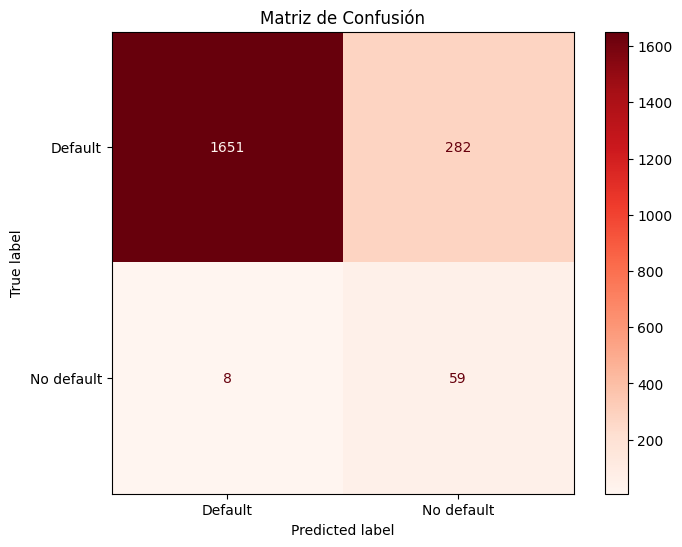


Reporte de Clasificación:
              precision    recall  f1-score   support

  No Default       1.00      0.85      0.92      1933
     Default       0.17      0.88      0.29        67

    accuracy                           0.85      2000
   macro avg       0.58      0.87      0.60      2000
weighted avg       0.97      0.85      0.90      2000


Curva Precision/Recall para regresión logísitca con class_weight='balanced':


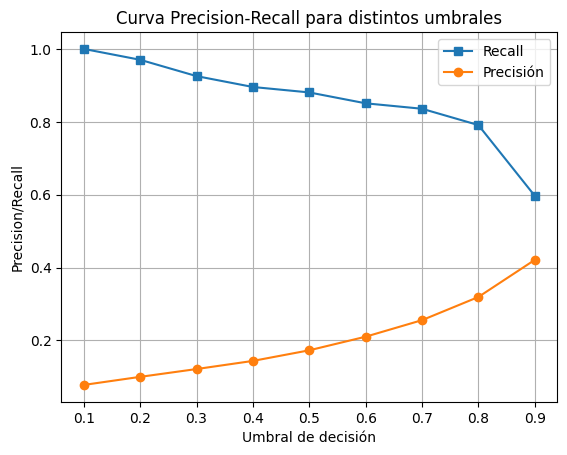

In [181]:
# Nueva carga y procesamiento de datos
data_default = load_data('Default')

# Nueva conversión de los datos a DataFrame y Series 
# ------> x: valriables predictoras
# ------> y: variable objetivo
# ------> Conversión de categóricas a numéricas
data_default_processed = pd.get_dummies(data_default, columns=['student'], drop_first=True, dtype=int)
data_default_processed['default'] = data_default_processed['default'].apply(lambda x: 1 if x == 'Yes' else 0)
X = data_default_processed[['balance', 'income', 'student_Yes']]
y = data_default_processed['default']

print("Primeras filas de los datos preprocesados:")
display(X.head())
# ------------------------------------------------------------------------------------------

# Nueva división de los datos (entrenamiento y tests)
# ------> Usamos train_test_split para separar los datos.
# ------> separamos el 20% de los datos para pruebas
# ------> usamos 42 como semilla para la aleatoriedad
# ------> usamos stratify para mantener la proporción de clases en y
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"X_train (muestras de entrenamiento, cant. de vbles predictoras) >> {X_train.shape}")
print(f"X_test (muestras para pruebas, cant. de vbles predictoras) >> {X_test.shape}")
# ------------------------------------------------------------------------------------------

# Nueva estandarización de los datos
# ------> Instanciamos el escalador
scaler = StandardScaler()
cols_to_scale = ['balance', 'income']
# ------> Creamos copias de los conjuntos de entrenamiento y prueba para no modificar los originales
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
# ------> Ajustamos y transformamos los datos de entrenamiento
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
# ------> Transformamos los datos de prueba con el escalador ya ajustado
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

print("Primeras filas de los datos de entrenamiento escalados:")
display(X_train_scaled.head())
# ------------------------------------------------------------------------------------------

# Instanciamos el modelo de regresión logística
log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

print("¡Modelo entrenado exitosamente con datos escalados con el parámetro class_weight='balanced'!")
# ------------------------------------------------------------------------------------------

# Realizamos predicciones sobre el conjunto de prueba escalado
y_pred = log_reg.predict(X_test_scaled)  
# ------> Calculamos y visualizamos la matriz de confusión
matriz_data_default = confusion_matrix(y_test, y_pred)
visualizacion_data_default = ConfusionMatrixDisplay(confusion_matrix=matriz_data_default, display_labels=['Default', 'No default'])
fig, ax = plt.subplots(figsize=(8, 6))
visualizacion_data_default.plot(cmap='Reds', ax=ax)
ax.set_title('Matriz de Confusión')
plt.show()
# ------> Imprimimos el reporte de clasificación completo
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['No Default', 'Default']))
# ------------------------------------------------------------------------------------------

# Técnica de ajuste de umbral
from sklearn.metrics import precision_score, recall_score
umbrales = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
precisiones = []
recalls = []

for umbral in umbrales:
    y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]
    y_pred_nuevo_umbral = (y_pred_proba >= umbral).astype(int)
    # ------> Guardamos Precisión y Recall para graficar luego
    precisiones.append(precision_score(y_test, y_pred_nuevo_umbral))
    recalls.append(recall_score(y_test, y_pred_nuevo_umbral))

print("\nCurva Precision/Recall para regresión logísitca con class_weight='balanced':")
plt.plot(umbrales, recalls, marker='s', label='Recall')
plt.plot(umbrales, precisiones, marker='o', label='Precisión')
plt.xlabel('Umbral de decisión')
plt.ylabel('Precision/Recall')
plt.title('Curva Precision-Recall para distintos umbrales')
plt.legend()
plt.grid(True)
plt.show()
